# A Comprehension of Intelligent Document Processing

Intelligent Document Processing (IDP) is an advanced automation technology that transforms the way businesses handle documents. By leveraging artificial intelligence (AI), IDP systems can automatically read, understand, and process vast quantities of documents, extracting crucial data and feeding it into various business workflows. This technology is a significant leap from traditional Optical Character Recognition (OCR) as it not only digitizes text but also comprehends the context and structure of the information within documents.

At its core, IDP is designed to tackle the challenge of processing unstructured and semi-structured data, which make up a large portion of business documents such as invoices, contracts, emails, and forms. By automating the extraction and interpretation of this data, IDP significantly reduces the need for manual data entry, leading to increased efficiency, higher accuracy, and substantial cost savings.

<br><br>

---
<br><br>

### The Inner Workings of Intelligent Document Processing

The power of IDP lies in its sophisticated multi-step process that intelligently handles documents from ingestion to data delivery. This process typically involves several key stages:

**1. Document Ingestion:** The first step involves importing documents from various sources and in multiple formats, including scanned paper documents, PDFs, Word files, and images.

**2. Pre-processing:** To enhance the quality of the input, documents undergo a pre-processing stage. This includes techniques like noise reduction, image enhancement, and deskewing to improve the accuracy of subsequent data extraction.

**3. Document Classification:** Using machine learning algorithms, the IDP system automatically categorizes documents based on their layout and content. This allows the system to differentiate between an invoice, a purchase order, or a legal contract, for instance.

**4. Data Extraction:** This is the core function of IDP. Advanced AI technologies, including Natural Language Processing (NLP) and computer vision, are employed to identify and extract relevant data fields. For example, from an invoice, it can pull out the invoice number, date, vendor name, and line-item details.

**5. Data Validation:** The extracted data is then validated against predefined rules and existing databases to ensure accuracy and consistency. Any exceptions or discrepancies can be flagged for human review in a "human-in-the-loop" process, which also helps to train and improve the AI model over time.

**6. Integration:** Finally, the structured and validated data is seamlessly integrated into downstream business systems such as Enterprise Resource Planning (ERP), Customer Relationship Management (CRM), or other databases, making the information readily available for further processing and analysis.


From **finance departments** automating invoice processing and expense management to **healthcare organizations** streamlining patient record management and claims processing, IDP is proving to be a game-changer. Even  **human resources** can expedite resume screening and employee onboarding. As the technology continues to evolve, its applications are expected to expand even further, solidifying its role as a cornerstone of modern digital transformation.

# Our Approach

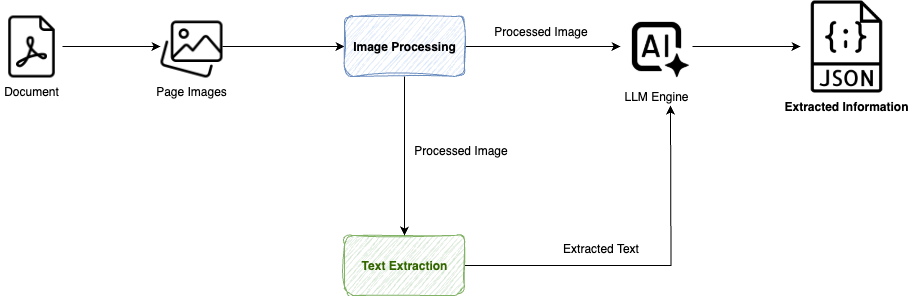

# SROIEv2: The Receipts Dataset

## Getting the data

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("urbikn/sroie-datasetv2")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sroie-datasetv2' dataset.
Path to dataset files: /kaggle/input/sroie-datasetv2


In [2]:
! cat /kaggle/input/sroie-datasetv2/SROIE2019/test/entities/X00016469670.txt

{
    "company": "OJC MARKETING SDN BHD",
    "date": "15/01/2019",
    "address": "NO 2 & 4, JALAN BAYU 4, BANDAR SERI ALAM, B1750 MASAI, JOHOR",
    "total": "193.00"
}

Since these are single-paged images already, we don't need to convert them

## Understanding the data


The downloaded dataset contains two major folders:
1. **train**: This folder contains the training data.
2. **test**: This folder contains the test data.

Each of these folders contains the following subfolders:
1. **img**: This folder containing the images of the receipts.
2. **box**: This folder containing the bounding box information of the text in the images and the text inside the bounding boxes. The file is a text file with the same name as the image file but with a .txt extension. The format of the file is as follows:
    ```
    x1, y1, x2, y2, x3, y3, x4, y4, text
    ```
    where (x1, y1), (x2, y2), (x3, y3), and (x4, y4) are the coordinates of the bounding box and text is the text inside the bounding box.
3. **entities**: This folder contains the ground truth information of the entities in the receipts. The file is a text file with the same name as the image file but with a .txt extension. The file contains json data with the following format:
    ```json
    {
        "company": "COMPANY_NAME",
        "date": "DATE",
        "address": "ADDRESS",
        "total": "TOTAL",
    }
    ```

## Image Preprocesing: OpenCV

In [3]:
! pip install opencv-python matplotlib numpy

Let's take one image and play with it.

In [4]:
import os
one_image_path = os.path.join(path, 'SROIE2019', 'train', 'img', 'X51005453729.jpg')

In [5]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def display_image(image, title="Image"):
    plt.figure(figsize=(7, 7))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

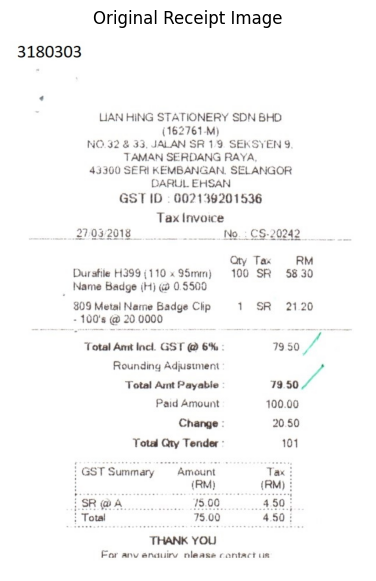

In [6]:
one_image = cv2.imread(one_image_path)
display_image(one_image, "Original Receipt Image")

### Grayscale Conversion

**Why?** Color information is usually not necessary for reading the text on a receipt. Converting the image to grayscale simplifies it from three color channels (Red, Green, Blue) to a single channel (intensity/brightness). This reduces computational complexity and is a required first step for many subsequent operations like thresholding.

In [7]:
# Convert the image to grayscale
def convert_to_grayscale(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

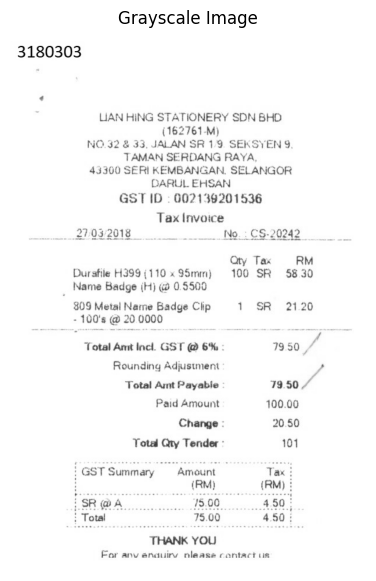

In [8]:
grayscale_image = convert_to_grayscale(one_image)
display_image(grayscale_image, "Grayscale Image")

### Noise (blur) Reduction
**Why?** Scanned images or photos often contain "noise" (random variations in brightness or color). This can look like small specks or graininess, which can confuse OCR algorithms. Applying a slight blur helps to smooth out this noise. A **Gaussian blur** is a common choice as it effectively averages out pixel values with a weighted average, preserving edges better than a simple blur.

In [9]:
def reduce_noise(gray_image):
  return cv2.GaussianBlur(gray_image, (5, 5), 0)

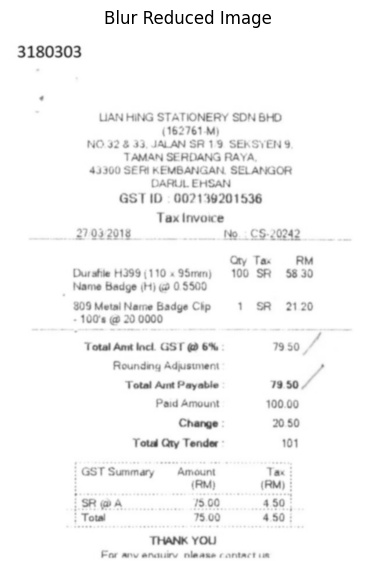

In [10]:
blur_reduced_image = reduce_noise(grayscale_image)
display_image(blur_reduced_image, "Blur Reduced Image")

### Binarization (Thresholding)

**Why?** This is one of the most critical steps. Binarization converts the grayscale image into a pure black-and-white image. The goal is to make the text **black** and the background **white**. However, receipts often have uneven lighting or shadows, so a simple (global) threshold won't work well. We use **adaptive thresholding**, which calculates a different threshold for smaller regions of the image, making it robust to lighting changes.

`cv2.adaptiveThreshold()`:

  * `cv2.ADAPTIVE_THRESH_GAUSSIAN_C`: Calculates the threshold for a pixel based on a weighted sum of neighborhood values.
  * `cv2.THRESH_BINARY_INV`: Inverts the result. We want the text to be white pixels (value 255) and the background black (value 0) for the next step (skew correction), which often works by finding white pixel contours.
  * `11`: The size of the neighborhood area (block size).
  * `4`: A constant subtracted from the mean. It's a fine-tuning parameter.

In [11]:
def binarize_image(blur_reduced_image):
  return cv2.adaptiveThreshold(
    blur_reduced_image,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, # Invert the colors (text becomes white)
    11, # Block size
    4  # Constant C
  )

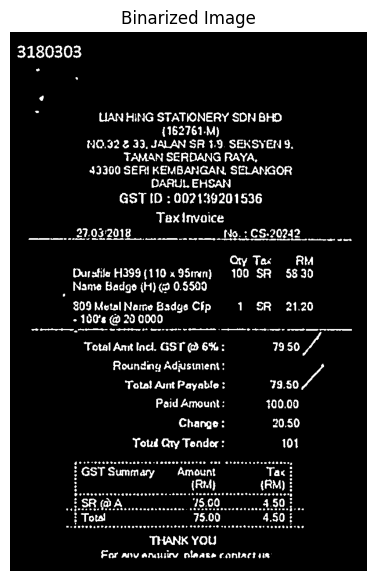

In [12]:
binarized_image = binarize_image(blur_reduced_image)
display_image(binarized_image, "Binarized Image")

### Skew Correction

**Why?** Receipts are often scanned or photographed at a slight angle. This skew can significantly reduce the accuracy of OCR. We need to detect this angle and rotate the image to make the text perfectly horizontal.

A common technique is to find the angle of the minimum-area bounding box that encloses all the text (the white pixels in our binarized image) and then rotate the original image by that angle.

In [13]:
def deskew_image(image):
    """
    Corrects the skew of an image by finding the minimum area rectangle
    of the text block and rotating accordingly.
    """
    # Find all non-zero (white) pixels
    coords = cv2.findNonZero(image)

    # Get the minimum area bounding rectangle
    # It returns (center(x,y), (width, height), angle of rotation)
    rect = cv2.minAreaRect(coords)
    angle = rect[-1] - 90

    # The `cv2.minAreaRect` angle has a specific range.
    # We need to adjust it for our rotation.
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = angle

    # Get the rotation matrix and rotate the image
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
                             flags=cv2.INTER_CUBIC,
                             borderMode=cv2.BORDER_REPLICATE)
    print(f"Detected skew angle: {angle:.2f} degrees")

    # Now, rotate the original grayscale image by the same angle
    (h, w) = rotated.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed_gray = cv2.warpAffine(rotated, M, (w, h),
                                  flags=cv2.INTER_CUBIC,
                                  borderMode=cv2.BORDER_REPLICATE)

    return deskewed_gray

In [14]:
deskewed_image = deskew_image(binarized_image)

Detected skew angle: -2.91 degrees


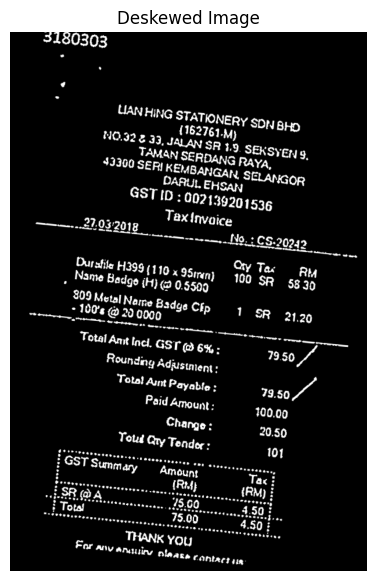

In [15]:
display_image(deskewed_image, "Deskewed Image")

Let's run the above code for all images

In [16]:
def process_one_image(image):
  image = convert_to_grayscale(image)
  print("Converted image to grayscale..")
  image = reduce_noise(image)
  print("Reduced noise in the image..")
  image = binarize_image(image)
  print("Binarized the image..")
  image = deskew_image(image)
  print("Corrected image orientation..")
  return image

In [17]:
import time
output_folder_path = "/content/processed_images"
start_time = time.time()

if os.makedirs(output_folder_path, exist_ok=True):
  print(f"Created folder: {output_folder_path}")


for image_name in os.listdir(os.path.join(path, 'SROIE2019', 'train', 'img'))[:20]:
  print(f"Processing image: {image_name}")
  image_path = os.path.join(path, 'SROIE2019', 'train', 'img', image_name)
  image = cv2.imread(image_path)
  processed_image = process_one_image(image)
  # save image
  output_path = os.path.join(output_folder_path, image_name)
  cv2.imwrite(output_path, processed_image)
  print(f"Saved processed image to: {output_path}")
  print("-"*50)

print("Processing images is completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Processing image: X51007231344.jpg
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: -0.45 degrees
Corrected image orientation..
Saved processed image to: /content/processed_images/X51007231344.jpg
--------------------------------------------------
Processing image: X51005442344.jpg
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: -1.10 degrees
Corrected image orientation..
Saved processed image to: /content/processed_images/X51005442344.jpg
--------------------------------------------------
Processing image: X51008142030.jpg
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: 0.00 degrees
Corrected image orientation..
Saved processed image to: /content/processed_images/X51008142030.jpg
--------------------------------------------------
Processing image: X51005447853.jpg
Converted image to grayscale..
Reduced noise in the image..


## Text Extraction: Tesseract

Tesseract OCR is a powerful and widely-used open-source optical character recognition (OCR) engine. In simple terms, it's a software that can "read" text from images and convert it into machine-readable text. This means you can take a picture of a document, a sign, or any other object containing text, and Tesseract can extract that text so you can edit, search, or analyze it.

### A Brief History and Development

Originally developed by Hewlett-Packard in the 1980s, Tesseract was later open-sourced in 2005 and has been sponsored by Google since 2006. This has led to significant improvements and made it one of the most accurate and versatile free OCR engines available. The latest versions of Tesseract utilize long short-term memory (LSTM), a type of recurrent neural network (RNN), which has greatly enhanced its ability to recognize text with high accuracy.



### Core Functionalities and Capabilities

Tesseract boasts a rich set of features that make it a flexible tool for various applications:

  * **Extensive Language Support:** Tesseract can recognize over 100 languages, making it a truly global OCR solution. It also supports multiple scripts and can even be trained to recognize new languages.
  * **Multiple Output Formats:** It can output the recognized text in various formats, including plain text, HTML, PDF, and TSV (tab-separated values). This allows for easy integration with other software and workflows.
  * **Page Segmentation Modes:** Tesseract offers different page segmentation modes, which help in correctly identifying the layout of a document, including columns, paragraphs, and blocks of text.
  * **Character Recognition and Confidence:** Not only does it recognize characters, but it can also provide a confidence score for each recognized character, word, or line. This is useful for assessing the accuracy of the OCR process.
  * **Command-Line and API Access:** Tesseract can be used as a command-line tool for quick and simple OCR tasks. For more complex integrations, it provides an API that allows developers to incorporate its OCR capabilities into their own applications. Popular wrappers like Pytesseract make it easy to use Tesseract with programming languages like Python.


### Installation
`pip install pytesseract pillow`


### How to Use Tesseract

For developers, integrating Tesseract into an application is straightforward using its API. Here is a simple example using the `pytesseract` wrapper in Python:

```python

from PIL import Image
import pytesseract


text = pytesseract.image_to_string(Image.open(filename))

print(text)
```



### Common Use Cases and Applications

The ability to extract text from images opens up a vast range of applications across various industries:

  * **Document Digitization:** Converting scanned documents, books, and historical archives into searchable digital text.
  * **Data Entry Automation:** Automating the process of entering data from invoices, receipts, and forms.
  * **Accessibility:** Assisting visually impaired individuals by converting printed text into speech.
  * **License Plate Recognition:** In law enforcement and traffic management systems.
  * **Social Media Monitoring:** Analyzing text within images shared on social media platforms.
  * **Translation:** Extracting text from an image and then using a translation service to translate it.

While Tesseract is a powerful tool, the accuracy of its output heavily depends on the quality of the input image. For best results, images should be clear, well-lit, and have a high resolution. Pre-processing steps like resizing, noise reduction, and converting to grayscale can significantly improve OCR accuracy.

In [18]:
! pip install pytesseract pillow

In [20]:
from PIL import Image
import pytesseract
import os

# Check if the directory exists and list its contents
processed_images_dir = '/content/processed_images'
if not os.path.exists(processed_images_dir):
    print(f"Error: Directory not found: {processed_images_dir}")
else:
    image_files = os.listdir(processed_images_dir)
    if not image_files:
        print(f"No images found in {processed_images_dir}")
    else:
        # Process the first image found in the directory
        first_image_path = os.path.join(processed_images_dir, image_files[0])
        print(f"Attempting to open and process: {first_image_path}")
        try:
            text = pytesseract.image_to_string(Image.open(first_image_path))
            print("Extracted text:")
            print(text)
        except FileNotFoundError:
            print(f"Error: File not found after listing: {first_image_path}")
        except Exception as e:
            print(f"An error occurred during text extraction: {e}")

Attempting to open and process: /content/processed_images/X51008142030.jpg
Extracted text:
 

 

en aes eNO STA NTRS BC
GaSe

. NO.1, TAMAN SRI DENGKIL, JALAN AIR HITAM

43800 DENGKIL, SELANGOR.

(GST Reg; No : 000670224384)

Tax Invoice
Table 37
Bi1]#:V001-539829 nec) sees shh
Date : 05-06-2018 20:23:14

CCN Cy Pax(s): 0
Qty Description (eye a),
D 15.00 SR
ie ce ;
i. iH) mn SR
Vege ee) (8)
1 ys
SE OCM RS CTRet ML Tac MST eT
| OS
- Beverage
Total (Excluding GST): 52.00
Total (Inclusive of GST): BYAAt)
‘TOTAL: 52.00
- Closed: Uae omeAU he mmm RSS AHS
- Server: i CASHIER
CASH : Ryan
ees sy eMC ENA GA)

SR Car 52,00° 0,00

oe en ee ae of
mace ee A ot

en



In [21]:
from PIL import Image
import pytesseract
import time

input_folder_path = "/content/processed_images"
output_folder_path = "/content/tesseract_output"
start_time = time.time()

if os.makedirs(output_folder_path, exist_ok=True):
  print(f"Created folder: {output_folder_path}")

total_images = sum(1 for entry in os.scandir(input_folder_path))
print(f"Total images in folder: {total_images}")

for i, image_name in enumerate(os.listdir(input_folder_path)[:20], 1):
  print(f"Processing image {i}/{total_images}: {image_name}")
  image_path = os.path.join(input_folder_path, image_name)
  print("Extracting text from image..")
  text = pytesseract.image_to_string(Image.open(image_path))
  output_path = os.path.join(output_folder_path, image_name.replace(".jpg", ".txt"))
  with open(output_path, "w") as f:
    f.write(text)

  print(f"Saved extracted text to {output_path}")
  print("-"*50)

print("Text Extraction Completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Total images in folder: 20
Processing image 1/20: X51008142030.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X51008142030.txt
--------------------------------------------------
Processing image 2/20: X51007419197.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X51007419197.txt
--------------------------------------------------
Processing image 3/20: X51005361897.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X51005361897.txt
--------------------------------------------------
Processing image 4/20: X51005442344.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X51005442344.txt
--------------------------------------------------
Processing image 5/20: X51005447853.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X51005447853.txt
--------------------------------------------------
Processing image 6/20: X51007231344.jp

## Information Extraction

In [25]:
prompt = """
Extract the information from the given image.
Information to be extracted: company, date, address, total.
The image has been converted to grayscale, noise reduced, binarized, and deskewed using opencv.
Always give your response in the following format:
{
    "company": "COMPANY_NAME",
    "date": "DATE",
    "address": "ADDRESS",
    "total": "TOTAL",
}
Also, the text has been extracted from the image using tesseract.
Use the extracted text as support for extracting information.
If you believe the extraction is incorrect somewhere, you may correct it yourself and provide corrected information.
Respond with the extracted information only in the specified format.
Here is the text:


"""

Can we improve the prompt using the [Unified Framework For An Effective Prompt](https://www.geeksforgeeks.org/data-science/a-unified-framework-for-an-effective-prompt/)?

In [26]:
from google import genai
from google.colab import userdata # colab only code
from PIL import Image
import json
import time

In [27]:
genai_client = genai.Client(api_key=userdata.get('GOOGLE_API_KEY'))

In [ ]:
image_folder_path = "/content/processed_images"
text_folder_path = "/content/tesseract_output"
output_folder_path = "/content/json_output"

start_time = time.time()

if os.makedirs(output_folder_path, exist_ok=True):
  print(f"Created folder: {output_folder_path}")

total_images = sum(1 for entry in os.scandir(image_folder_path))
print(f"Total images in folder: {total_images}")

for i, image_name in enumerate(os.listdir(input_folder_path)[:20], 1):
  print(f"Processing image {i}/{total_images}: {image_name}")
  image_path = os.path.join(input_folder_path, image_name)
  print(f"Loading image: {image_path}")
  with open(image_path, "rb") as f:
    image = Image.open(image_path)


  text_path = os.path.join(text_folder_path, image_name.replace(".jpg", ".txt"))
  print(f"Loading extracted text: {text_path}")
  with open(text_path, "r") as f:
    text = f.read()

  print("Extracting information from image and text..")

  prompt = prompt + text



  contents = [
        image,
        {
            "text": prompt
        }
    ]
  response = genai_client.models.generate_content(model='gemini-1.5-flash', contents=contents)

  # Access the usage_metadata attribute
  usage_metadata = response.usage_metadata

  # Print the different token counts
  print(f"Input Token Count: {usage_metadata.prompt_token_count}")
  print(f"Thoughts Token Count: {response.usage_metadata.thoughts_token_count}")
  print(f"Output Token Count: {usage_metadata.candidates_token_count}")
  print(f"Total Token Count: {usage_metadata.total_token_count}")

  extracted_information = json.loads(response.text.replace('```json', '').replace('```', ''))
  output_path = os.path.join(output_folder_path, image_name.replace(".jpg", ".json"))
  with open(output_path, "w") as f:
    json.dump(extracted_information, f, indent=4)

  print(f"Saved extracted information to {output_path}")
  print("-"*50)
  time.sleep(60)

print("Information Extraction Completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Total images in folder: 626
Processing image 1/626: X51006619758.jpg
Loading image: /content/processed_images/X51006619758.jpg
Loading extracted text: /content/tesseract_output/X51006619758.txt
Extracting information from image and text..
Input Token Count: 649
Thoughts Token Count: None
Output Token Count: 110
Total Token Count: 759
Saved extracted information to /content/json_output/X51006619758.json
--------------------------------------------------
Processing image 2/626: X51005676546.jpg
Loading image: /content/processed_images/X51005676546.jpg
Loading extracted text: /content/tesseract_output/X51005676546.txt
Extracting information from image and text..
Input Token Count: 989
Thoughts Token Count: None
Output Token Count: 92
Total Token Count: 1081
Saved extracted information to /content/json_output/X51005676546.json
--------------------------------------------------
Processing image 3/626: X51005361883.jpg
Loading image: /content/processed_images/X51005361883.jpg
Loading extract

ServerError: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}

# Can you play with a Resume Dataset?

https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset

# **Assignment: Build a Smart Resume Parser**
### The goal is now to create a pipeline that can take an image of a resume and extract key information like the applicant's name, contact details, skills, and work experience into a structured JSON format.

In [31]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snehaanbhawal/resume-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'resume-dataset' dataset.
Path to dataset files: /kaggle/input/resume-dataset


In [32]:
import os

dataset_path = "/kaggle/input/resume-dataset"

print(f"Contents of '{dataset_path}':")
print(os.listdir(dataset_path))

data_folder_path = os.path.join(dataset_path, 'data')
if os.path.exists(data_folder_path):
    print(f"\nContents of '{data_folder_path}':")
    print(os.listdir(data_folder_path))

    if os.listdir(data_folder_path):
        first_category = os.listdir(data_folder_path)[0]
        category_path = os.path.join(data_folder_path, first_category)
        if os.path.isdir(category_path):
            print(f"\nContents of the first category folder '{first_category}':")
            print(os.listdir(category_path)[:5]) # Show first 5 files

Contents of '/kaggle/input/resume-dataset':
['Resume', 'data']

Contents of '/kaggle/input/resume-dataset/data':
['data']

Contents of the first category folder 'data':
['DESIGNER', 'BPO', 'FINANCE', 'CONSTRUCTION', 'SALES']


In [33]:
import os

# Path to the DESIGNER category folder
designer_resumes_path = "/kaggle/input/resume-dataset/data/data/DESIGNER"

print(f"First 5 files in '{designer_resumes_path}':")

if os.path.exists(designer_resumes_path):
    files = os.listdir(designer_resumes_path)
    print(files[:5])
else:
    print(f"Directory not found: {designer_resumes_path}")

First 5 files in '/kaggle/input/resume-dataset/data/data/DESIGNER':
['22506245.pdf', '13998435.pdf', '67582956.pdf', '34349255.pdf', '26790545.pdf']


## PDF to Image Conversion

In [34]:
!pip install pdf2image
!apt-get install -q poppler-utils

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.10 [186 kB]
Fetched 186 kB in 0s (939 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126435 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.10_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.10) ...
Setting up poppler-utils (22.02.0-2ubuntu0.10) ...
Processing triggers for man-db (2.10.2-1) ...


Converting '/kaggle/input/resume-dataset/data/data/DESIGNER/22506245.pdf' to images...
Successfully converted the PDF into 1 pages (images).

Displaying the first page:


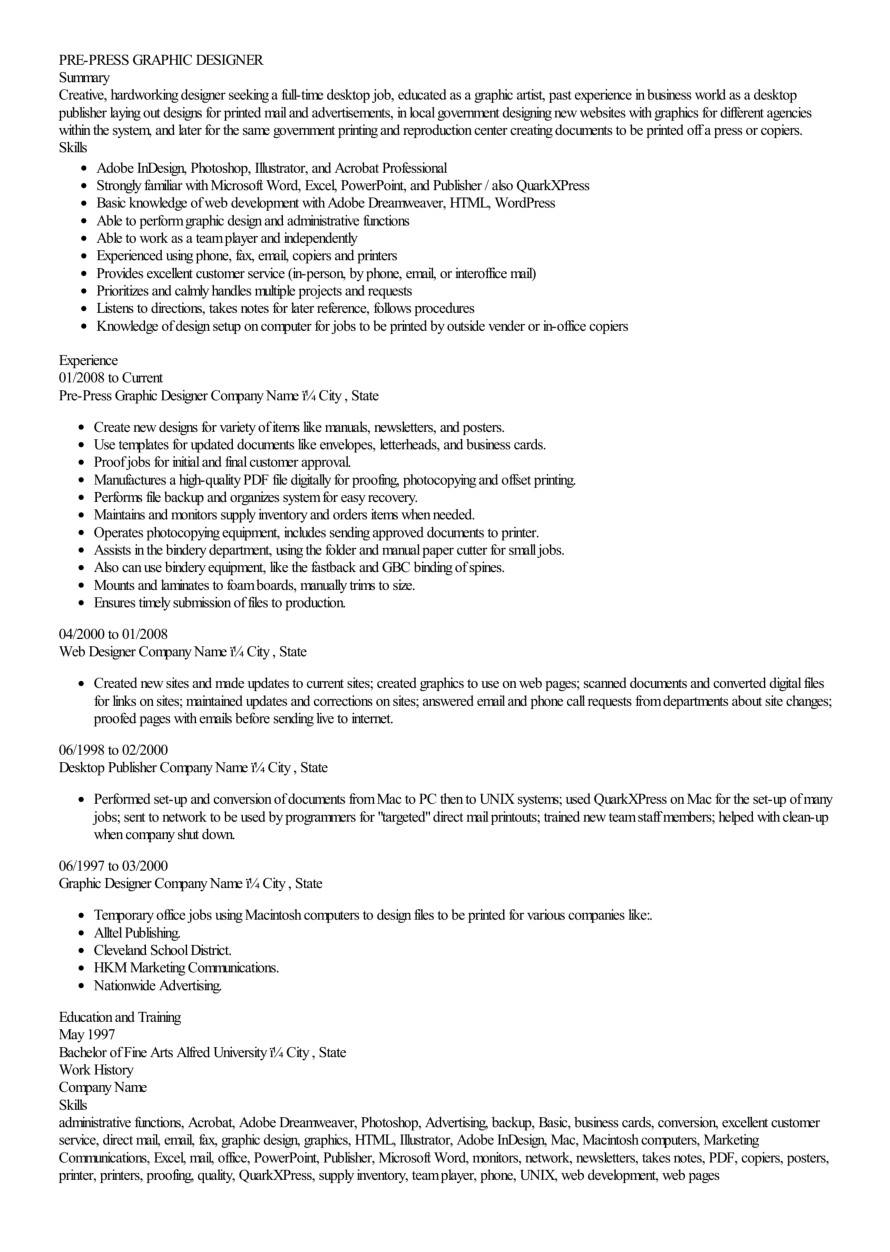

In [35]:
import os
from pdf2image import convert_from_path
import matplotlib.pyplot as plt

pdf_filename = "22506245.pdf"
pdf_path = os.path.join("/kaggle/input/resume-dataset/data/data/DESIGNER", pdf_filename)

print(f"Converting '{pdf_path}' to images...")

# PDF to a list of PIL Image
try:
    images = convert_from_path(pdf_path)
    print(f"Successfully converted the PDF into {len(images)} pages (images).")

    # first page
    if images:
        print("\nDisplaying the first page:")
        plt.figure(figsize=(12, 16))
        plt.imshow(images[0])
        plt.axis('off')
        plt.show()
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure the file path is correct and the libraries were installed successfully.")

## Image Preprocessing

Preprocessing each page...
Successfully preprocessed 1 pages.

Displaying the preprocessed first page:


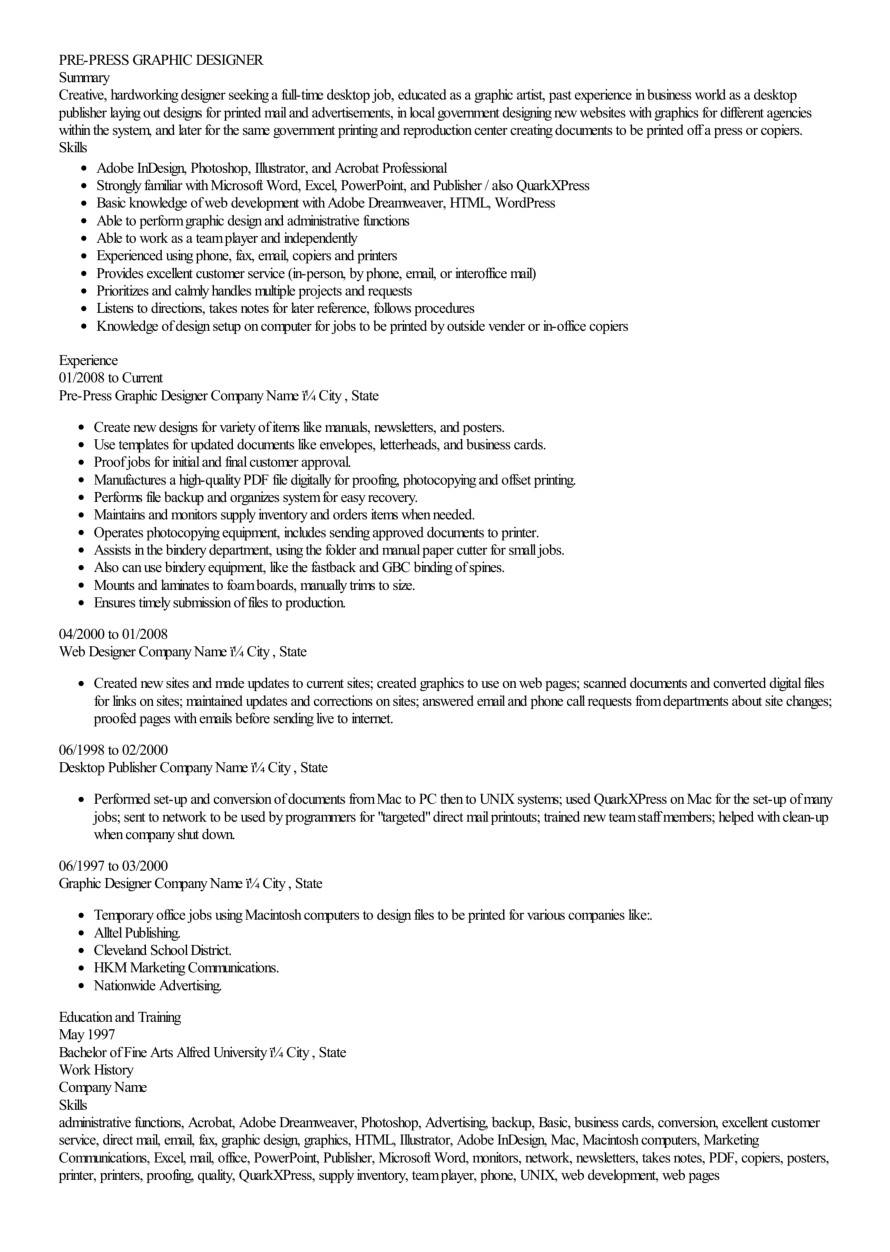

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def preprocess_image(image):

    open_cv_image = np.array(image)
    open_cv_image = open_cv_image[:, :, ::-1].copy()

    gray_image = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Binarize and invert colors
    binarized_image = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 4
    )

    # Skew Correction
    coords = cv2.findNonZero(binarized_image)
    rect = cv2.minAreaRect(coords)
    angle = rect[-1]

    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    (h, w) = gray_image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    deskewed_image = cv2.warpAffine(
        gray_image, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
    )
    return deskewed_image

print("Preprocessing each page...")
preprocessed_images = []
for img in images:
    processed = preprocess_image(img)
    preprocessed_images.append(processed)

print(f"Successfully preprocessed {len(preprocessed_images)} pages.")

# first preprocessed page
if preprocessed_images:
    print("\nDisplaying the preprocessed first page:")
    plt.figure(figsize=(12, 16))
    plt.imshow(preprocessed_images[0], cmap='gray')
    plt.axis('off')
    plt.show()

## Extracting the Text

In [37]:
!pip install pytesseract

In [40]:
import pytesseract
from PIL import Image

print("Extracting text from all preprocessed pages...")

full_text = ""
for image_array in preprocessed_images:

    pil_image = Image.fromarray(image_array)
    text = pytesseract.image_to_string(pil_image)

    full_text += text + "\n\n--- Page Break ---\n\n"

print("Text extraction complete!")

#first 1000 characters
print("\nStart of Extracted Text (First 1000 Chars)")
print(full_text[:1000])
print("...")
print(" End of Preview ")

Extracting text from all preprocessed pages...
Text extraction complete!

Start of Extracted Text (First 1000 Chars)
PRE-PRESS GRAPHIC DESIGNER.
Summary

Creative, hardworking designer seeking a full-time desktop job, educated as a graphic artist, past experience in business world as a desktop
publisher laying out designs for printed mail and advertisements, in local government designing new websites with graphics for different agencies
within the system, and later for the same government printing and reproduction center creating documents to be printed offa press or copiers.
Skill

 

 

Adobe InDesign, Photoshop, Illustrator, and Acrobat Professional

Strongly familiar with Microsoft Word, Excel, PowerPoint, and Publisher / also QuarkXPress

Basic knowledge of web development with Adobe Dreamweaver, HTML, WordPress

Able to perform graphic design and administrative fiinctions

Able to work as a team player and independently

Experienced using phone, fax, email, copiers and printers



In [ ]:
import google.generativeai as genai
from google.colab import userdata
import json

genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

resume_prompt_template_v2 = """
Extract the key information from the provided resume text.
The text has been extracted from a PDF using an OCR process.
If you find errors in the text, please try to infer the correct information.

**Important: If a specific piece of information (like name, email, or phone) is not found in the text, you MUST return `null` for that field.** Do not invent information.

Extract the following information and provide your response only in the specified JSON format:
- name: The full name of the applicant.
- email: The email address.
- phone: The phone number.
- skills: A list of key skills.
- experience: A list of job experiences, where each job is an object with "company", "role", and "duration".
- education: A list of educational qualifications, where each is an object with "degree", "institution", and "year".

Format:
{{
    "name": "Full Name" or null,
    "email": "email@address.com" or null,
    "phone": "123-456-7890" or null,
    "skills": ["Skill 1", "Skill 2", "Skill 3"],
    "experience": [
        {{
            "company": "Company Name",
            "role": "Job Title",
            "duration": "Start Year - End Year"
        }}
    ],
    "education": [
        {{
            "degree": "Degree Name",
            "institution": "University/College Name",
            "year": "Graduation Year"
        }}
    ]
}}

Here is the text:

{extracted_text}
"""

def extract_info_with_gemini_from_text(text_from_resume):
    """
    Uses Gemini to extract structured information from a text prompt.

    """
    model = genai.GenerativeModel('gemini-1.5-flash')

    prompt = resume_prompt_template_v2.format(extracted_text=text_from_resume)

    response = model.generate_content(prompt)

    try:
        cleaned_text = response.text.replace('```json', '').replace('```', '').strip()
        start_index = cleaned_text.find('{')
        end_index = cleaned_text.rfind('}') + 1

        if start_index == -1 or end_index == 0:
            print("!! ERROR: Could not find a JSON object in the model's response. !!")
            print(f"   Raw response was:\n---\n{response.text}\n---")
            return None

        json_string = cleaned_text[start_index:end_index]
        return json.loads(json_string)

    except (json.JSONDecodeError, IndexError) as e:
        print(f"\n!! FAILED TO PARSE JSON !!")
        print(f"   Error: {e}")
        print(f"   Raw response was:\n \n{response.text}\n")
        return None

extracted_data = extract_info_with_gemini_from_text(full_text)

if extracted_data:
    print("\nExtracted Information")
    print(json.dumps(extracted_data, indent=4))


Extracted Information
{
    "name": null,
    "email": null,
    "phone": null,
    "skills": [
        "Adobe InDesign",
        "Photoshop",
        "Illustrator",
        "Acrobat Professional",
        "Microsoft Word",
        "Excel",
        "PowerPoint",
        "Publisher",
        "QuarkXPress",
        "Adobe Dreamweaver",
        "HTML",
        "WordPress",
        "graphic design",
        "web development",
        "administrative functions",
        "customer service",
        "team player",
        "file backup",
        "supply inventory",
        "proofing",
        "direct mail",
        "Mac",
        "Macintosh computers"
    ],
    "experience": [
        {
            "company": "Company Name",
            "role": "Pre-Press Graphic Designer",
            "duration": "01/2008 to Current"
        },
        {
            "company": "Company Name",
            "role": "Web Designer",
            "duration": "04/2000 to 01/2008"
        },
        {
            "c

## Information Extraction


# **Conclusion**

* Built an end-to-end **IDP pipeline** to extract structured JSON from unstructured resume PDFs.
* Combined **OpenCV preprocessing**, **Tesseract OCR**, and **Gemini LLM** for accurate data extraction.

---

### **Methodology Highlights**

* **PDF to Image**: Converted multi-page PDFs to images.
* **Image Preprocessing**: Applied grayscale, noise reduction, adaptive thresholding, and skew correction.
* **OCR Extraction**: Tesseract extracted raw text.
* **LLM Structuring**: Gemini parsed text into clean, structured JSON, handling missing data robustly.

---

### **Key Findings**

* **Preprocessing is critical** for accurate OCR results.
* **LLM excels** at contextual understanding and structuring unorganized text.
* **Handling missing data** via prompt adjustments prevents errors.

---

### **Future Improvements**

* **Batch processing** for multiple resumes.
* **Accuracy evaluation** against a ground-truth dataset.
* **User interface** via Flask/Streamlit for real-time uploads.
* **Expanded field extraction** for skills, experience, and projects.

---

**This project demonstrates that combining OCR preprocessing with LLMs enables accurate, scalable, and structured extraction from unstructured documents.**
